In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt
import matplotlib.cm                     as cm
import matplotlib.animation              as animation

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
OutputDir   = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/Rect_100Instants_TransRotScale_Rand_/')
FigDir      = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

RandxyFlg   = False
RandtFlg    = False

Nt          = 100
Nx          = 200
Ny          = 200

RotFlg      = True
TransFlg    = True
ScaleFlg    = True

PlotFlg     = False
SaveFlg     = False
n_modes_vec = [32,64,128]


ColorVec    = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/Orig/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

TempDir = OutputDir+'/train/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = OutputDir+'/test/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

In [3]:
# lx = 5.
# ly = 4.

# s  = 2

# Nx = 200
# Ny = 200

# Mat  = np.zeros((Nx,Ny))
# xrot = np.linspace(-10,10,Nx)
# yrot = np.linspace(-10,10,Ny)
# for ix, xrot_ in enumerate(xrot):
#     for iy, yrot_ in enumerate(yrot):
        
#         xrot_ = xrot_ * s
#         yrot_ = yrot_ * s
        
#         zx_1 = (np.tanh((xrot_+lx)*10) + np.tanh((lx-xrot_)*10))/2
#         zy_1 = (np.tanh((yrot_+ly)*10) + np.tanh((ly-yrot_)*10))/2
#         Mat[ix,iy] = np.exp(zx_1+zy_1)
        
        
# plt.figure()
# plt.imshow((Mat), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
# plt.xlabel('x')
# plt.ylabel('y')

# plt.figure()
# plt.plot(Mat[100,:])

Text(0, 0.5, '$\\theta$ [deg]')

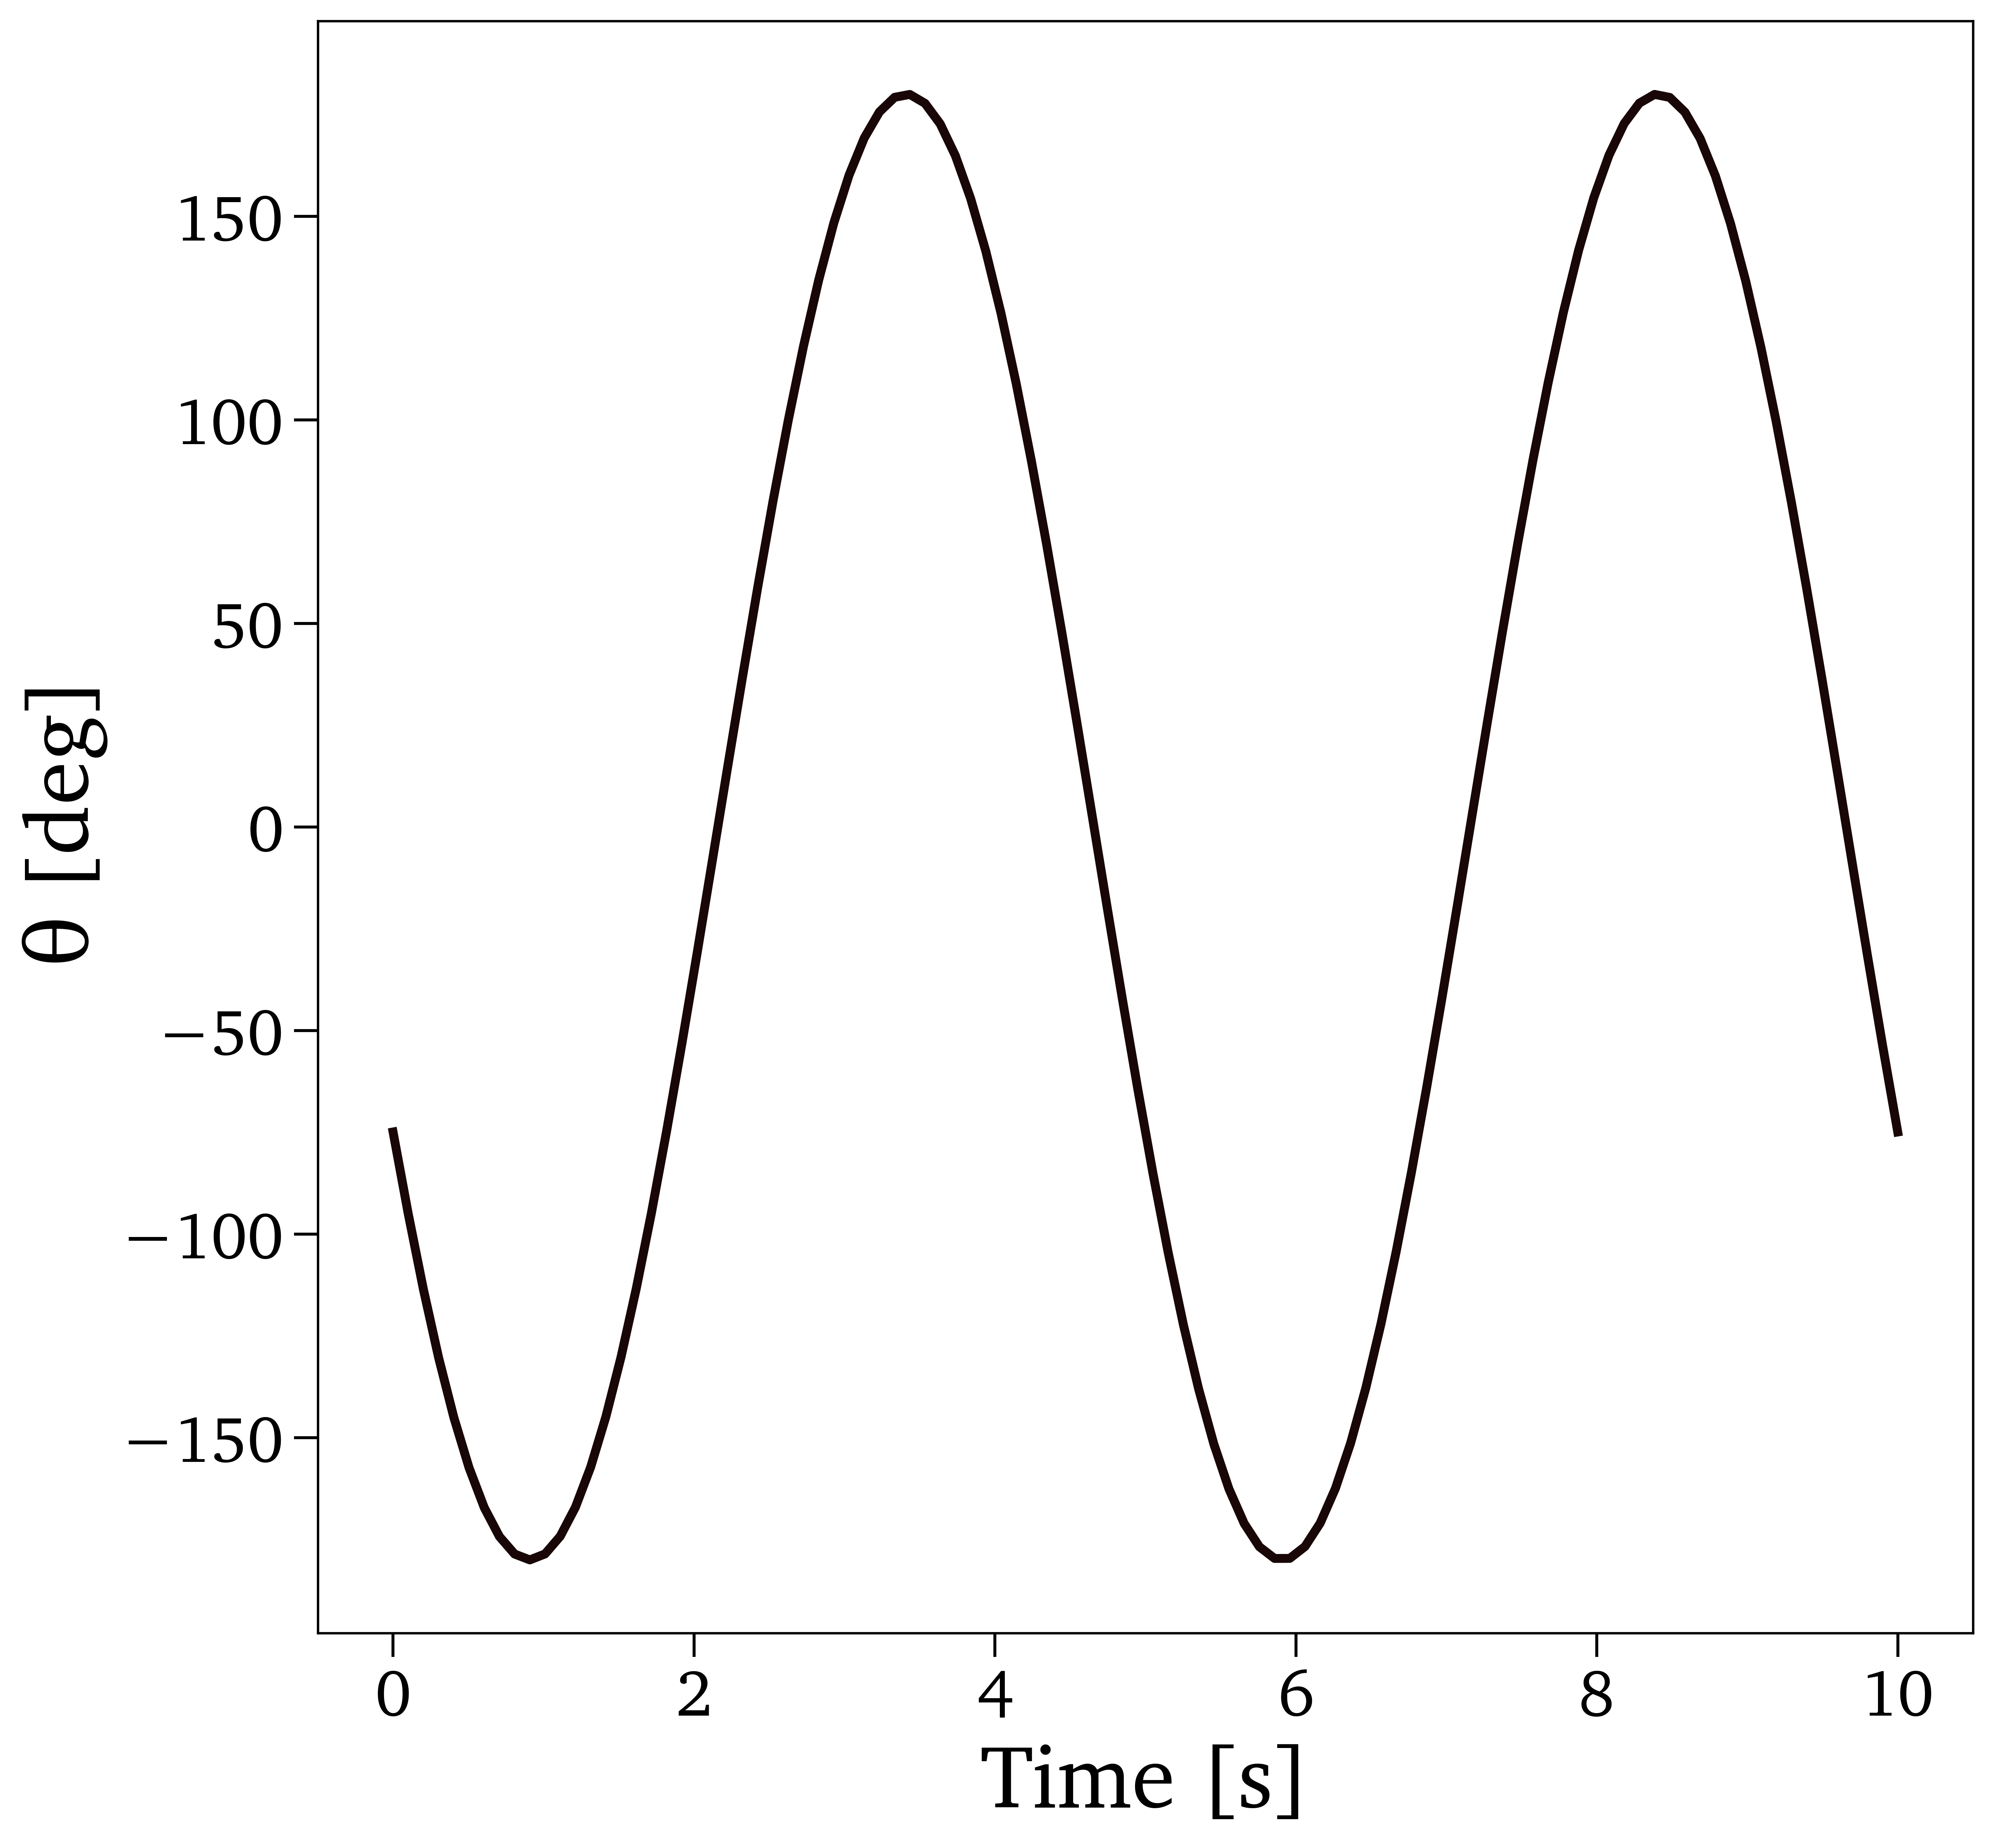

In [4]:
Theta0  = 0./180*np.pi
w_Theta = 36./180*np.pi

tVec    = np.linspace(0.,10.,100)

#Theta   = Theta0 + w_Theta*tVec
Theta   = Theta0 + np.cos(tVec/10.*(4*np.pi)+2.)*np.pi
    
plt.plot(tVec,Theta*180/np.pi,'-')

plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [deg]')

Text(0, 0.5, '$y_c$')

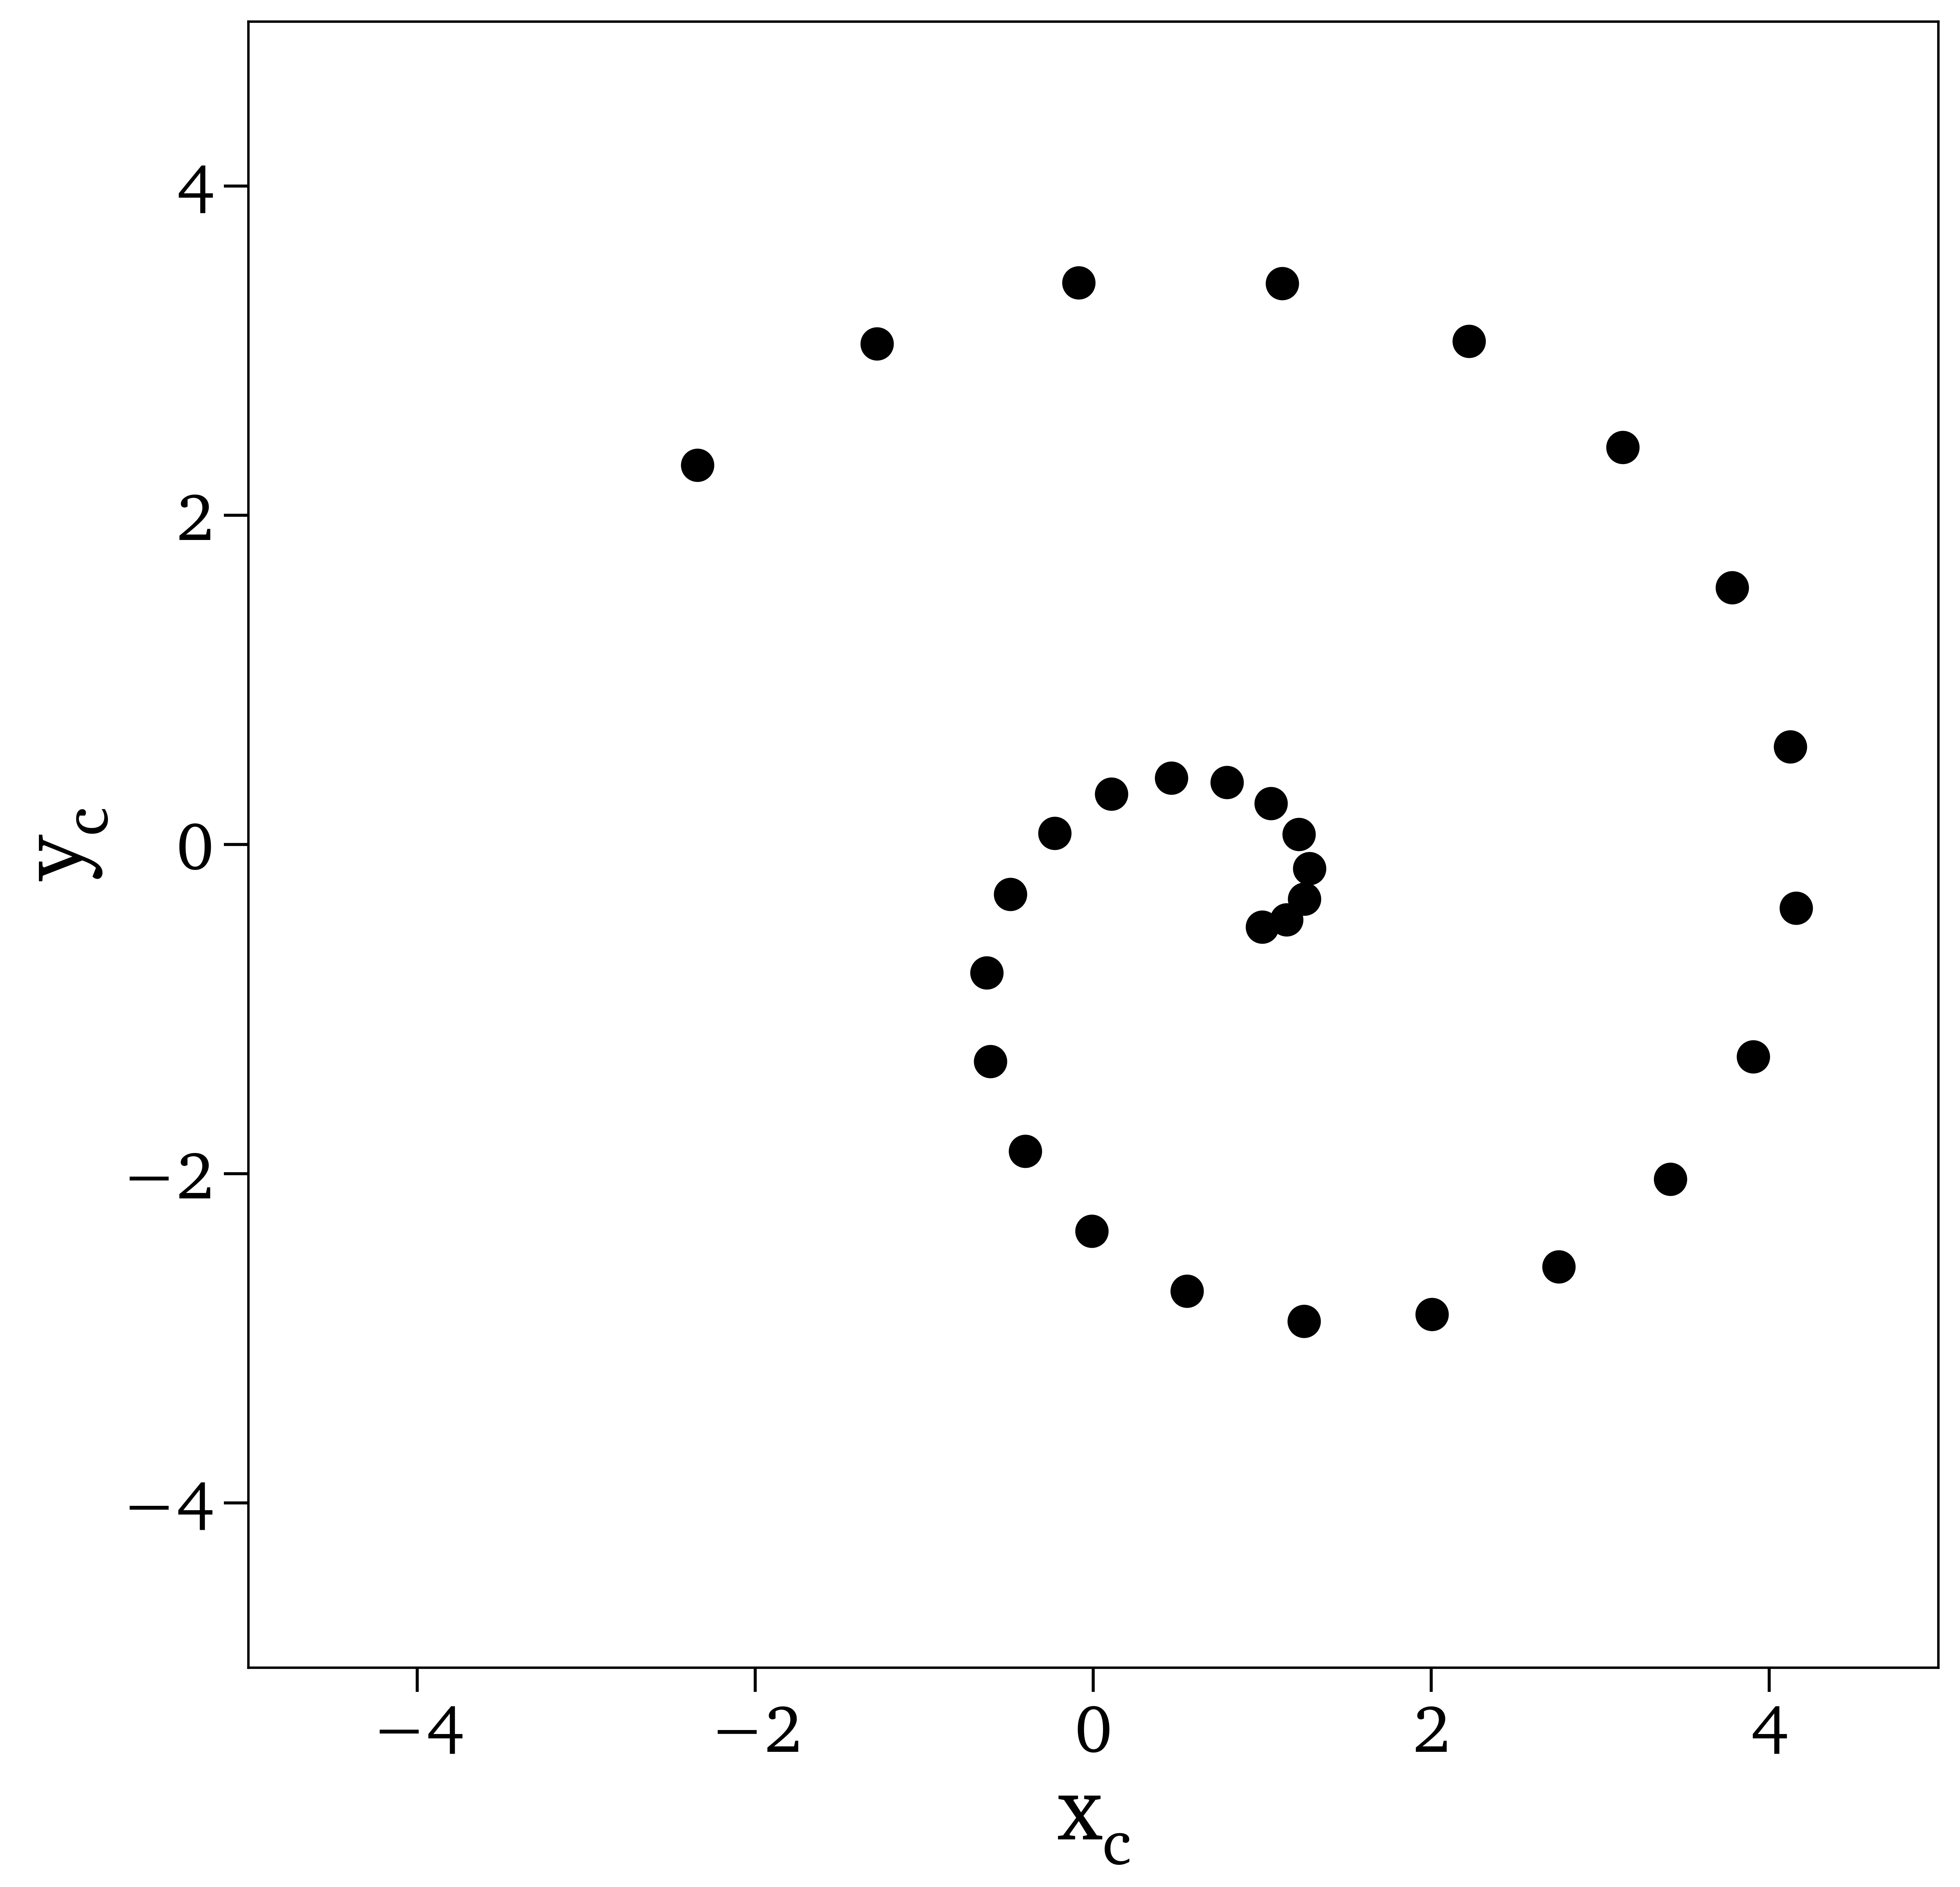

In [5]:
w_Psi = 50./180*np.pi
ca    = 0.5
cx0   = 1.
cy0   = -0.5

tVec    = np.linspace(0.,10.,30)
for it, t in enumerate(tVec):
    Psi   = t*w_Psi
    cr    = ca * Psi
    cx    = cx0 + cr * np.cos(Psi)
    cy    = cy0 + cr * np.sin(Psi)    
    
    plt.plot(cx,cy,'ko')
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    
plt.xlabel(r'$x_c$')
plt.ylabel(r'$y_c$')

Text(0, 0.5, 'Scalings')

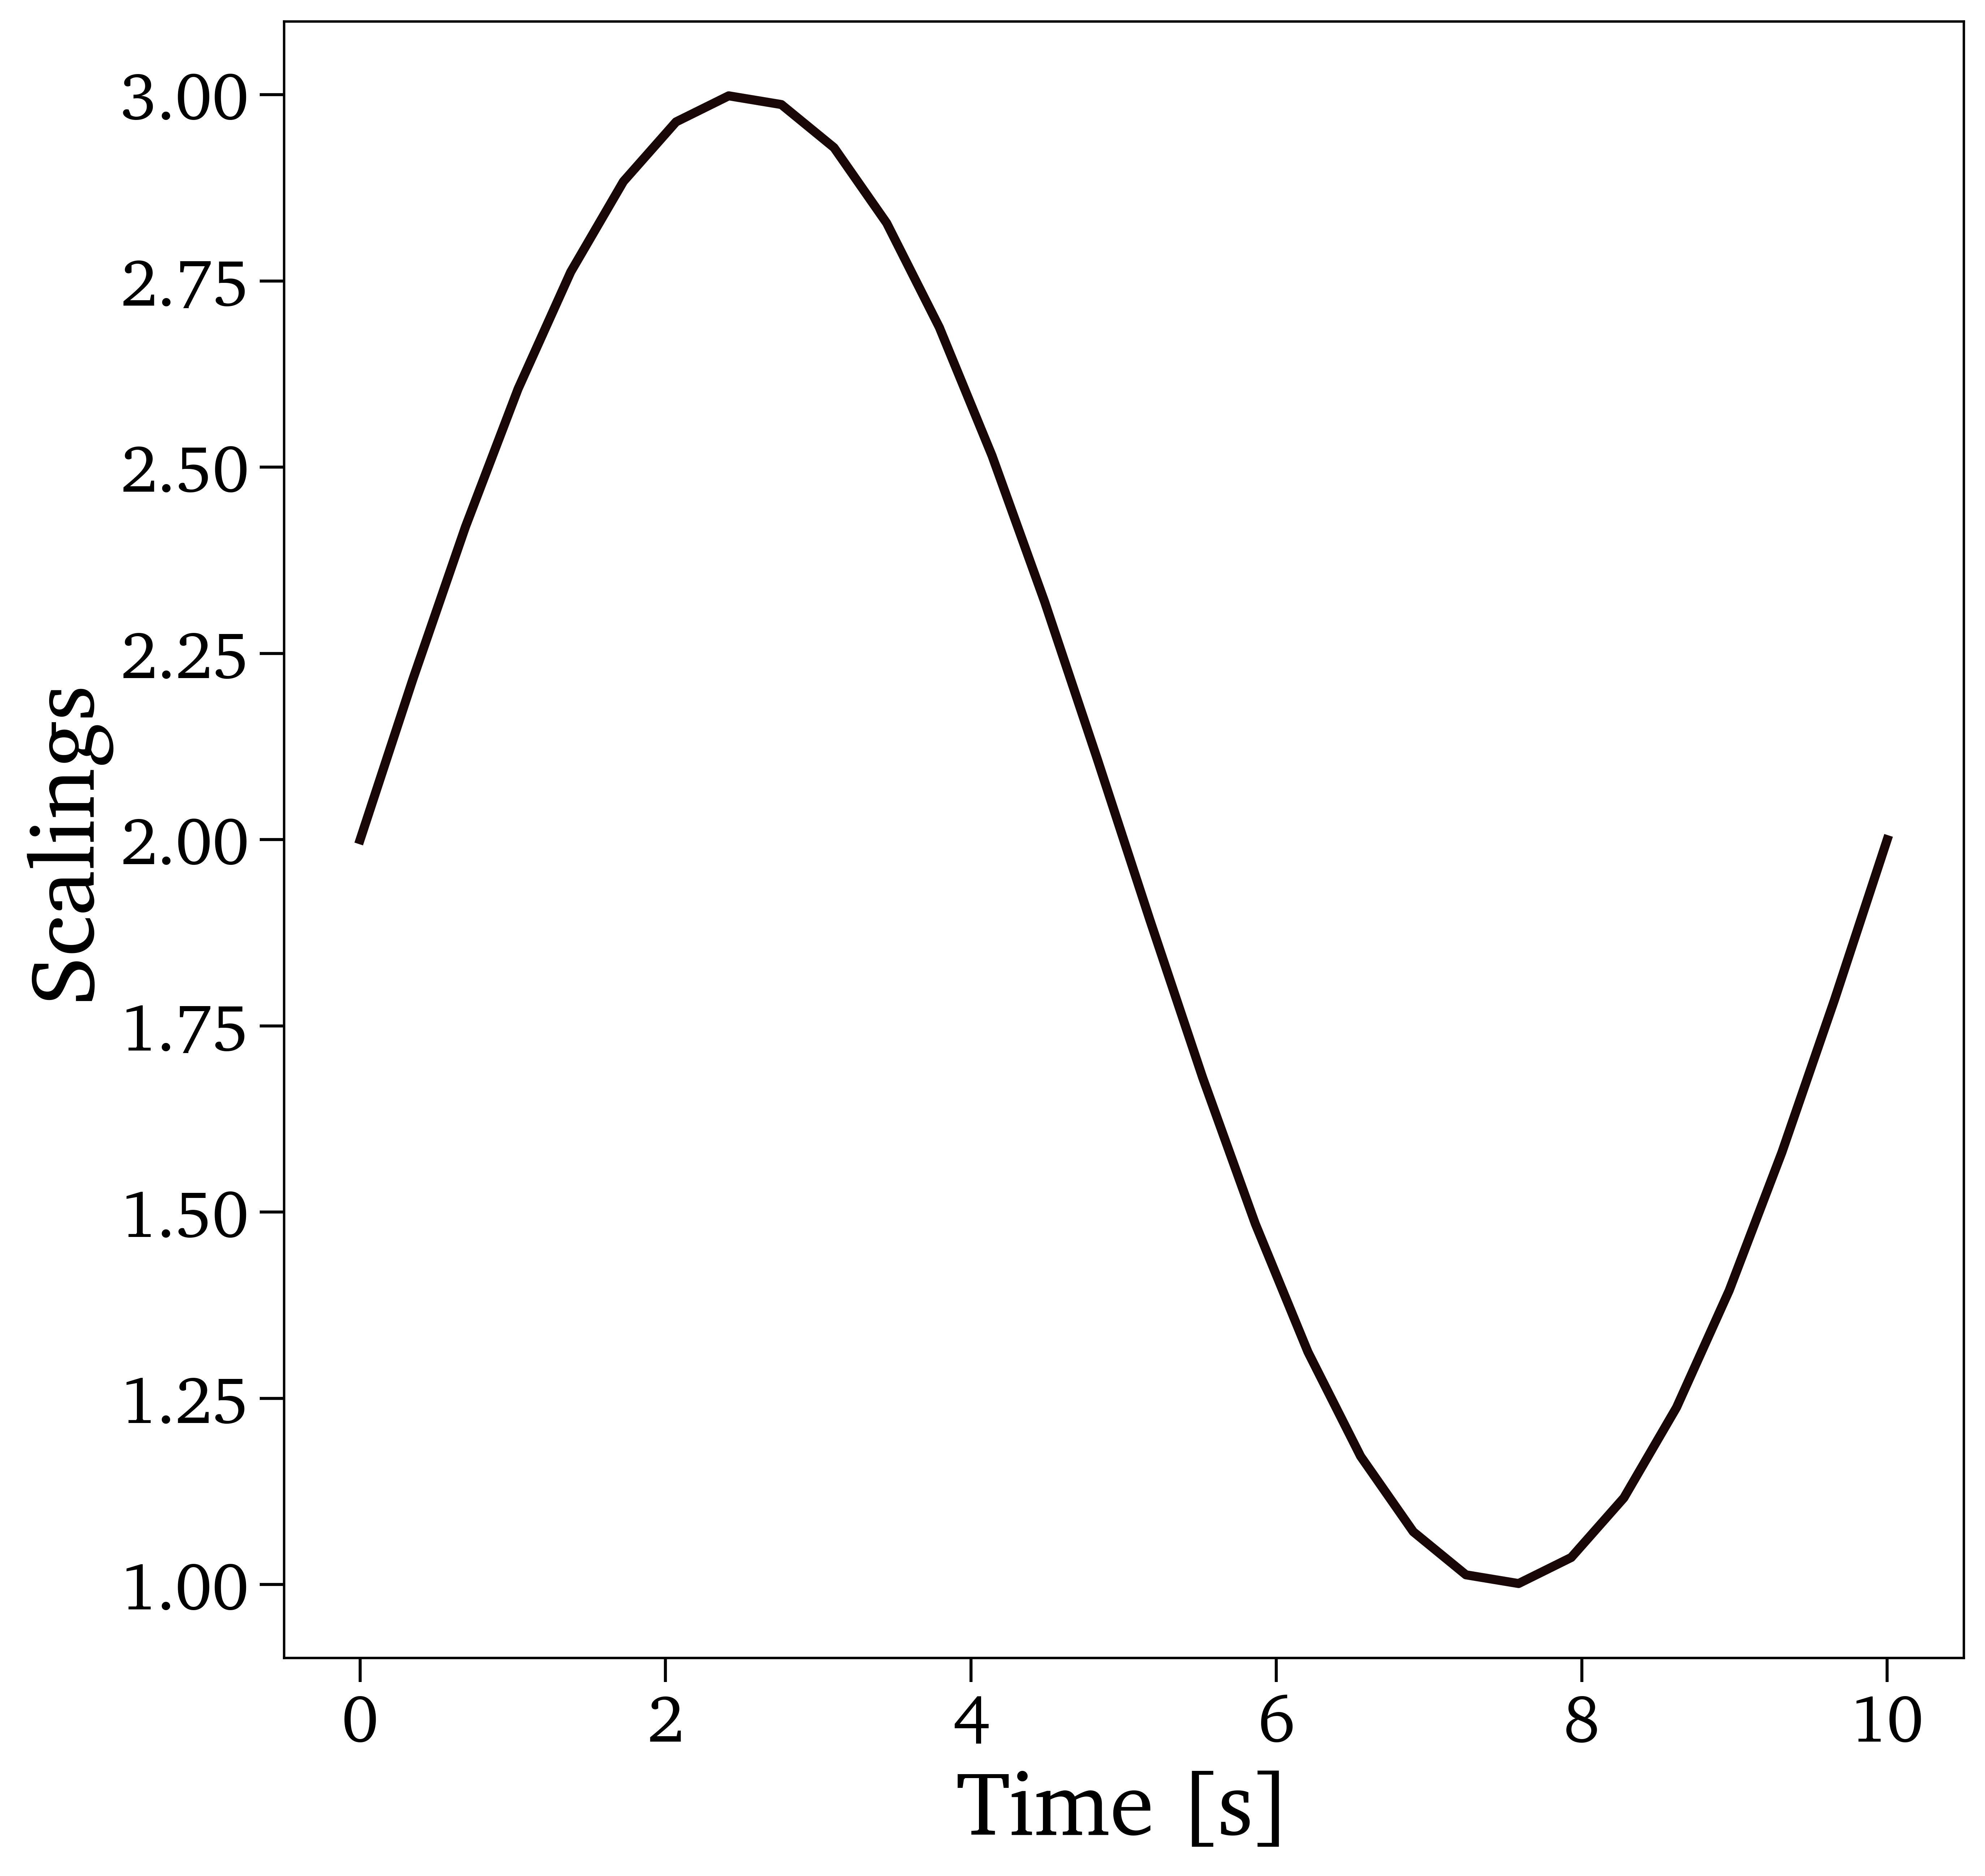

In [6]:
lx0   = 8.
ly0   = 6.

tEnd    = 10.
tVec    = np.linspace(0.,tEnd,30)
s       = (np.sin(tVec/tEnd*360. / 180.*np.pi)+2)
    
plt.plot(tVec,s)
plt.xlabel('Time [s]')
plt.ylabel('Scalings')

In [7]:
v_zz  = 0.2
zz0   = 1.

tVec    = np.linspace(0.,10.,30)
for it, t in enumerate(tVec):
    zz  = zz0 + t*v_zz

In [8]:
xMin    = -10.
xMax    = 10.
yMin    = -10.
yMax    = 10.

t0      = 0.
tEnd    = 10.


if (not RandtFlg):
    
    if (PlotFlg):
        tVec = np.linspace(0,10,16)
    else:
        tVec = np.linspace(t0,tEnd,Nt)
    XX       = np.zeros((Nx*Ny,Nt))
    jt       = 0
    for it, t in enumerate(tVec):
        if (t < 5.5 or t > 5.5):
            print('it=', it, '; t=',t)

            if (RotFlg == True):
                Theta = Theta0 + w_Theta*t
                Theta = Theta0 + np.cos(t*4./10.*(np.pi)+2.)*np.pi
            else:
                Theta = Theta0

            if (TransFlg == True):
                Psi   = t*w_Psi
                cr    = ca * Psi
                cx    = cx0 + cr * np.cos(Psi)
                cy    = cy0 + cr * np.sin(Psi)  
            else:
                cx    = 0.
                cy    = 0.

            if (ScaleFlg == True):
                s    = (np.sin(t/tEnd*360. / 180.*np.pi)+2.)
            else:
                s     = 1

            zz    = zz0 + t*v_zz


            II_  = np.zeros((Nx*Ny,2))
            TT_  = np.zeros((Nx*Ny,1))
            OO_  = np.zeros((Nx*Ny,1))
            Mat  = np.zeros((Nx,Ny))

            if (not RandxyFlg):
                x    = np.linspace(xMin,xMax,Nx)
                y    = np.linspace(yMin,yMax,Ny)

                i    = 0
                for ix, x_ in enumerate(x):
                    for iy, y_ in enumerate(y):
                        xrot_      = x_*np.cos(Theta) - y_*np.sin(Theta)
                        yrot_      = x_*np.sin(Theta) + y_*np.cos(Theta)
                        xrot_      = xrot_-cx
                        yrot_      = yrot_-cy
                        xrot_      = xrot_*s
                        yrot_      = yrot_*s
                        
#                         tanh_x_1   = np.tanh((xrot_-cx+lx/2)*10.)
#                         #tanh_x_2   = np.tanh((xrot_-cx     )*10.)
#                         tanh_x_3   = np.tanh((xrot_-cx-lx/2)*10.)
#                         tanh_y_1   = np.tanh((yrot_-cy+ly/2)*10.)
#                         #tanh_y_2   = np.tanh((yrot_-cy     )*10.)
#                         tanh_y_3   = np.tanh((yrot_-cy-ly/2)*10.)
#                         zx_1       = tanh_x_1 - tanh_x_3
#                         #zx_2       = tanh_x_1 - tanh_x_2
#                         zy_1       = tanh_y_1 - tanh_y_3
#                         #zy_2       = tanh_y_1 - tanh_y_3
                        zx_1 = (np.tanh((x_+lx0)*10) + np.tanh((lx0-x_)*10))/2
                        zy_1 = (np.tanh((y_+ly0)*10) + np.tanh((ly0-y_)*10))/2
                        II_[i,0]   = xrot_
                        II_[i,1]   = yrot_
                        TT_[i,0]   = t
                        OO_[i,0]   = np.exp(zx_1+zy_1)*zz
                        Mat[ix,iy] = np.exp(zx_1+zy_1)*zz
                        XX[i,it]   = np.exp(zx_1+zy_1)*zz

                        i+=1

            else:
                xy      = np.random.rand(Nx*Ny,2)
                xy[:,0] = xy[:,0]*(xMax-xMin) + xMin
                xy[:,1] = xy[:,1]*(yMax-yMin) + yMin

                for i in range(Nx*Ny):
                    x_         = xy[i,0]
                    y_         = xy[i,1]
                    xrot_      = x_*np.cos(Theta) - y_*np.sin(Theta)
                    yrot_      = x_*np.sin(Theta) + y_*np.cos(Theta)
                    xrot_      = xrot_-cx
                    yrot_      = yrot_-cy
                    xrot_      = xrot_*s
                    yrot_      = yrot_*s                    

#                     xrot_      = x_*np.cos(Theta) + y_*np.sin(Theta)
#                     yrot_      = x_*np.sin(Theta) - y_*np.cos(Theta)
#                     tanh_x_1   = np.tanh((xrot_-cx+lx/2)*10.)
#                     #tanh_x_2   = np.tanh((xrot_-cx     )*10.)
#                     tanh_x_3   = np.tanh((xrot_-cx-lx/2)*10.)
#                     tanh_y_1   = np.tanh((yrot_-cy+ly/2)*10.)
#                     #tanh_y_2   = np.tanh((yrot_-cy     )*10.)
#                     tanh_y_3   = np.tanh((yrot_-cy-ly/2)*10.)
#                     zx_1       = tanh_x_1 - tanh_x_3
#                     #zx_2       = tanh_x_1 - tanh_x_2
#                     zy_1       = tanh_y_1 - tanh_y_3
#                     #zy_2       = tanh_y_1 - tanh_y_2
                    zx_1       = (np.tanh((x_+lx0)*10) + np.tanh((lx0-x_)*10))/2
                    zy_1       = (np.tanh((y_+ly0)*10) + np.tanh((ly0-y_)*10))/2
                    II_[i,0]   = xrot_
                    II_[i,1]   = yrot_
                    TT_[i,0]   = t
                    OO_[i,0]   = np.exp(zx_1+zy_1)*zz
                    XX[i,it]   = np.exp(zx_1+zy_1)*zz

            if (it==0):
                II = II_
                OO = OO_
                TT = TT_
            else:
                II = np.concatenate([II,II_], axis=0)
                TT = np.concatenate([TT,TT_], axis=0)
                OO = np.concatenate([OO,OO_], axis=0)

            if (PlotFlg):
                plt.figure()
                plt.imshow((Mat).reshape(Nx,Ny), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
                plt.xlabel('x')
                plt.ylabel('y')
                plt.savefig(OutputDir+'/Rect_Orig_'+str(jt+1)+'.pdf', format='pdf', bbox_inches='tight')

            jt += 1
            
else:
    
    tVec     = np.random.rand(Nt*Nx*Ny)
    tVec     = tVec*(tEnd-t0) + t0

    xy       = np.random.rand(Nt*Ny*Ny,2)
    xy[:,0]  = xy[:,0]*(xMax-xMin) + xMin
    xy[:,1]  = xy[:,1]*(yMax-yMin) + yMin
    xy       = xy.T


    if (RotFlg == True):
        Theta = Theta0 + w_Theta*tVec
        Theta = Theta0 + np.cos(tVec*4./10.*(np.pi)+2.)*np.pi
    else:
        Theta = Theta0

    if (TransFlg == True):
        Psi   = tVec*w_Psi
        cr    = ca * Psi
        cx    = cx0 + cr * np.cos(Psi)
        cy    = cy0 + cr * np.sin(Psi)  
    else:
        cx    = 0.
        cy    = 0.

    if (ScaleFlg == True):
        s     = (np.sin(tVec/tEnd*360. / 180.*np.pi)+2.)
    else:
        s     = 1

    zz         = zz0 + tVec*v_zz

    xrot_      = xy[0,:]*np.cos(Theta) - xy[1,:]*np.sin(Theta)
    yrot_      = xy[0,:]*np.sin(Theta) + xy[1,:]*np.cos(Theta)
    xrot_      = xrot_-cx
    yrot_      = yrot_-cy
    xrot_      = xrot_*s
    yrot_      = yrot_*s 

#     xrot_      = xy[0,:]*np.cos(Theta) - xy[1,:]*np.sin(Theta)
#     yrot_      = xy[0,:]*np.sin(Theta) + xy[1,:]*np.cos(Theta)
#     tanh_x_1   = np.tanh((xrot_-cx+lx/2)*10.)
#     tanh_x_3   = np.tanh((xrot_-cx-lx/2)*10.)
#     tanh_y_1   = np.tanh((yrot_-cy+ly/2)*10.)
#     tanh_y_3   = np.tanh((yrot_-cy-ly/2)*10.)
#     zx_1       = tanh_x_1 - tanh_x_3
#     zy_1       = tanh_y_1 - tanh_y_3
    
    II         = np.zeros((Nt*Ny*Ny,2))
    II[:,0]    = xrot_
    II[:,1]    = yrot_
    
    zx_1       = (np.tanh((xy[0,:]+lx0)*10) + np.tanh((lx0-xy[0,:])*10))/2
    zy_1       = (np.tanh((xy[1,:]+ly0)*10) + np.tanh((ly0-xy[1,:])*10))/2
    OO         = (np.exp(zx_1+zy_1)*zz)[...,np.newaxis]
    TT         = tVec[...,np.newaxis]

it= 0 ; t= 0.0
it= 1 ; t= 0.10101010101010101
it= 2 ; t= 0.20202020202020202
it= 3 ; t= 0.30303030303030304
it= 4 ; t= 0.40404040404040403
it= 5 ; t= 0.5050505050505051
it= 6 ; t= 0.6060606060606061
it= 7 ; t= 0.7070707070707071
it= 8 ; t= 0.8080808080808081
it= 9 ; t= 0.9090909090909091
it= 10 ; t= 1.0101010101010102
it= 11 ; t= 1.1111111111111112
it= 12 ; t= 1.2121212121212122
it= 13 ; t= 1.3131313131313131
it= 14 ; t= 1.4141414141414141
it= 15 ; t= 1.5151515151515151
it= 16 ; t= 1.6161616161616161
it= 17 ; t= 1.7171717171717171
it= 18 ; t= 1.8181818181818181
it= 19 ; t= 1.9191919191919191
it= 20 ; t= 2.0202020202020203
it= 21 ; t= 2.121212121212121
it= 22 ; t= 2.2222222222222223
it= 23 ; t= 2.323232323232323
it= 24 ; t= 2.4242424242424243
it= 25 ; t= 2.525252525252525
it= 26 ; t= 2.6262626262626263
it= 27 ; t= 2.727272727272727
it= 28 ; t= 2.8282828282828283
it= 29 ; t= 2.929292929292929
it= 30 ; t= 3.0303030303030303
it= 31 ; t= 3.131313131313131
it= 32 ; t= 3.2323232323232323
it= 

In [ ]:
thr1       = 0.95
thr2       = 0.99
thr3       = 0.9999

tTry       = np.linspace(t0,tEnd,5)
if (n_modes_vec):
    
    
    pca        = PCAA(XX, scaling='std', n_components=XX.shape[1], nocenter=False)
    C          = pca.X_center
    D          = pca.X_scale
    L          = pca.L
    LL         = np.maximum(L,0.)
    
    plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
    
    vec        = np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL))
    plt.plot(np.arange(len(vec))+1, vec,'-o')


    kk1        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr1)+1
    plt.plot(kk1, vec[kk1-1], 'o', c=ColorVec[1])
    plt.hlines(vec[kk1-1], xmin=0, xmax=kk1, color=ColorVec[1])
    plt.vlines(kk1, ymin=0.1, ymax=vec[kk1-1], color=ColorVec[1])
    
    kk2        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr2)+1
    plt.plot(kk2, vec[kk2-1], 'o', c=ColorVec[2])
    plt.hlines(vec[kk2-1], xmin=0, xmax=kk2, color=ColorVec[2])
    plt.vlines(kk2, ymin=0.1, ymax=vec[kk2-1], color=ColorVec[2])
    
    kk3        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr3)+1
    
    plt.xlim([1, kk2+10])
    plt.ylim([0.1, 1.02])
    plt.xlabel(r'k')
    plt.ylabel('Cumulative Energy')
    #plt.xticks([1,5,10,15,20])
    #plt.yscale('log')
    plt.savefig(OutputDir+'/Rect_CumEnergy.eps', format='eps', bbox_inches='tight')
    
    
    
    jt = 0
    for t in tTry:
        it=0
        while tVec[it]<t:
            it+=1
        print(it)    
            
        plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/heavy.mplstyle'))
        plt.figure()
        plt.imshow((XX[:,it]).reshape(Nx,Ny), origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.savefig(OutputDir+'/Rect_Orig_'+str(jt+1)+'.pdf', format='pdf', bbox_inches='tight')
        #plt.savefig(OutputDir+'/XOrig_t'+str(tVec[it])+'.pdf', format='pdf', bbox_inches='tight')

        XX_Vec = []
        for n_modes in n_modes_vec:
            A        = pca.A[:,0:n_modes].T
            AT       = A.T

            XX_pca   = ((XX - C)/D).dot(AT)
            XX_      = (XX_pca.dot(A))*D + C
            

            plt.figure()
            plt.imshow((XX_[:,it]).reshape(Nx,Ny), origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
            plt.xlabel('x')
            plt.ylabel('y')
            plt.savefig(OutputDir+'/Rect_Orig_'+str(jt+1)+'_'+str(n_modes)+'PC.pdf', format='pdf', bbox_inches='tight')
            #plt.savefig(OutputDir+'/XRec_t'+str(tVec[it])+'_'+str(n_modes)+'PC.pdf', format='pdf', bbox_inches='tight')
            
            
            XX_Vec.append(XX_)

    
    
        plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
        plt.figure()
        y    = np.linspace(yMin,yMax,Ny)
        plt.plot(y, (XX[:,it]).reshape(Nx,Ny)[int(Nx/2),:],  '-', color=ColorVec[0], label='Data')
        for i_mode, n_modes in enumerate(n_modes_vec):
            plt.plot(y, (XX_Vec[i_mode][:,it]).reshape(Nx,Ny)[int(Nx/2),:], ':', color=ColorVec[i_mode+1], label=r'$N_{\eta}$='+str(n_modes))
        plt.xlabel('y')
        plt.ylabel('z')
        plt.legend()
        plt.savefig(OutputDir+'/Rect_Orig_Slice_'+str(jt+1)+'.eps', format='eps', bbox_inches='tight')
        #plt.savefig(OutputDir+'/XSlice_t'+str(tVec[it])+'.eps', format='eps', bbox_inches='tight')

        
        jt += 1

/usr/local/lib/python3.9/site-packages/PCAfold/reduction.py:193: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])


0
25
50
75


In [ ]:
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/video.mplstyle'))


img    = [] # some array of images
frames = [] # for storing the generated images
fig    = plt.figure(figsize=(10,8))
for it in range(XX.shape[1]):
    im     = plt.imshow((XX[:,it]).reshape(Nx,Ny), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
    plt.xlabel('x')
    plt.ylabel('y')
    frames.append([im])
    
ani = animation.ArtistAnimation(fig, frames, interval=5000, blit=True, repeat_delay=500000)
writergif = animation.PillowWriter(fps=30)
ani.save(OutputDir+'/Video.gif',writer=writergif)

In [ ]:
if (SaveFlg):

    
    from sklearn.model_selection import train_test_split

    try:
        os.makedirs(OutputDir+'/valid/')
    except:
        pass


    data_id    = 'pts'

    DataInput  = pd.DataFrame(np.concatenate((TT,II), axis=1), columns=['t','x','y'])
    DataOutput = pd.DataFrame(np.concatenate((TT,OO), axis=1), columns=['t','z'])

    n_points   = len(DataInput)

    idx                  = np.arange(n_points)
    train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

    n_valid              = len(valid_idx)
    n_train              = len(train_idx)

    try:
        os.makedirs(OutputDir+'/train/'+data_id+'/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/valid/'+data_id+'/')
    except:
        pass

    DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
    DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

    DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
    DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)